In [109]:
#!pip install prince
#!pip install impyute
#!pip install autoimpute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#import prince
#import impyute
import inflect

In [110]:
pd.options.mode.chained_assignment = None

In [111]:
# from google.colab import drive
# drive.mount('/content/drive')

In [112]:
sqf_cpw_filter = pd.read_csv('clean_sqf.csv')

In [113]:
sqf_cpw_filter = sqf_cpw_filter.drop(columns=['STOP_DURATION_MINUTES', 
                                              #'OBSERVED_DURATION_MINUTES',
                                              #'OFFICER_IN_UNIFORM_FLAG', 
                                              'FRISKED_FLAG'])

In [114]:
p = inflect.engine()

sqf_cpw_filter['YEAR2'] = sqf_cpw_filter['YEAR2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['MONTH2'] = sqf_cpw_filter['MONTH2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['DAY2'] = sqf_cpw_filter['DAY2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['STOP_LOCATION_PRECINCT'] = sqf_cpw_filter['STOP_LOCATION_PRECINCT'].apply(lambda x: p.number_to_words(int(x)))

In [115]:
# Convert to correct datatype --> object for categorical, float64 for numerical 
sqf_cpw_filter = sqf_cpw_filter.astype({'YEAR2': 'object',
                                        'OBSERVED_DURATION_MINUTES': 'float64',
                                        'OFFICER_IN_UNIFORM_FLAG': 'object',
                                        'STOP_LOCATION_PRECINCT': 'object',
                                        'LOCATION_IN_OUT_CODE': 'object', 'JURISDICTION_CODE': 'object',
                                        'SUSPECT_SEX': 'object', 'SUSPECT_RACE_DESCRIPTION': 'object',
                                        'SUSPECT_REPORTED_AGE': 'float64', 'SUSPECT_BODY_BUILD_TYPE': 'object',
                                        'SUSPECT_WEIGHT': 'float64', 'WEAPON_FOUND_FLAG': 'object', 
                                        'MONTH2': 'string', 'DAY2': 'string',
                                        'STOP_FRISK_TIME': 'float64'
                                        })

In [116]:
#sqf_cpw_filter = sqf_cpw_filter.drop(columns='FRISKED_FLAG')

In [117]:
sqf_cpw_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      13031 non-null  object 
 1   STOP_LOCATION_PRECINCT     13031 non-null  object 
 2   LOCATION_IN_OUT_CODE       10283 non-null  object 
 3   JURISDICTION_CODE          10735 non-null  object 
 4   OBSERVED_DURATION_MINUTES  13031 non-null  float64
 5   OFFICER_IN_UNIFORM_FLAG    13031 non-null  object 
 6   STOP_WAS_INITIATED         13031 non-null  object 
 7   SUSPECT_SEX                12998 non-null  object 
 8   SUSPECT_RACE_DESCRIPTION   13031 non-null  object 
 9   SUSPECT_REPORTED_AGE       12262 non-null  float64
 10  SUSPECT_WEIGHT             12720 non-null  float64
 11  SUSPECT_BODY_BUILD_TYPE    12882 non-null  object 
 12  WEAPON_FOUND_FLAG          13031 non-null  object 
 13  SUSPECT_HEIGHT             12699 non-null  flo

### Simple Imputation Function

In [118]:
# simple imputation 

def fill_missing_data(df):
    num_cols = df.select_dtypes(['float64', 'int64'])
    cat_cols = df.select_dtypes(['object', 'string'])
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])    
    return df

In [119]:
# # imputation (ascending order of missing values) after ohe

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# sqf_ohe = pd.get_dummies(sqf_cpw_filter, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
#                                                                    'LOCATION_IN_OUT_CODE', 
#                                                                    'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG', 
#                                                                    'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
#                                                                    'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
#                                                                    'SUSPECT_RACE_DESCRIPTION', 
#                                                                    'SUSPECT_BODY_BUILD_TYPE', 
#                                                                    'MONTH2', 'DAY2'])

# imputer = IterativeImputer(random_state=0)
# imputed = imputer.fit_transform(sqf_ohe)
# sqf_cpw_filter_itimp = pd.DataFrame(imputed, columns=sqf_ohe.columns)

### Preprocessing Functions

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [200]:
def standardize_data(df_num, t1=0.2, t2=0.25):
    print(t1, t2)
    train, test = train_test_split(df_num, test_size=t1, random_state=1)
    train, val = train_test_split(train, test_size=t2, random_state=1)
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(train)
    val_scale = scaler.transform(val)
    test_scale = scaler.transform(test)
    scaled_train = pd.DataFrame(train_scale, index=train.index, columns=train.columns)
    scaled_val = pd.DataFrame(val_scale, index=val.index, columns=val.columns)
    scaled_test = pd.DataFrame(test_scale, index=test.index, columns=test.columns)
    return scaled_train, scaled_val, scaled_test

In [201]:
def process_data_simpleimputer(sqf_cpw, t1=0.2, t2=0.25):
    weapon = 'WEAPON_FOUND_FLAG_Y'
    df_num = sqf_cpw.select_dtypes(['float64', 'int64'])
    df_cat = sqf_cpw.select_dtypes(['object', 'string'])
    cat = df_cat.columns
    df_ohe = pd.get_dummies(df_cat, prefix=cat, columns=cat, drop_first=True)
    train_cat, test_cat = train_test_split(df_ohe, test_size=0.2, random_state=1)
    train_cat, val_cat = train_test_split(train_cat, test_size=0.25, random_state=1)
    train_num, val_num, test_num = standardize_data(df_num, t1, t2)
    train = train_num.join(train_cat, how='outer')
    val = val_num.join(val_cat, how='outer')
    test = test_num.join(test_cat, how='outer')
    train_x = train.drop([weapon], axis=1)
    val_x = val.drop([weapon], axis=1)
    test_x = test.drop([weapon], axis=1)
    # targets
    targets_train = train[weapon]
    targets_val = val[weapon]
    targets_test = test[weapon]
    
    return train_x, val_x, test_x, targets_train, targets_val, targets_test

In [271]:
from sklearn.metrics import confusion_matrix
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(tn)
    #print(fp)
    specificity = tn / (tn+fp)
    return specificity 

In [430]:
def weighted_accuracy(true, pred):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos 
    frac_pos = num_pos/num_labels 
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    #print(weight_pos)
    #print(weight_neg)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true): 
        num_pos_correct += (pred_i == true_i and true_i == 1) 
        num_neg_correct += (pred_i == true_i and true_i == 0) 
        weighted_accuracy = ((weight_pos * num_pos_correct) 
                             + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg)) 
    return weighted_accuracy 

In [182]:
sqf_cpw_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      13031 non-null  object 
 1   STOP_LOCATION_PRECINCT     13031 non-null  object 
 2   LOCATION_IN_OUT_CODE       10283 non-null  object 
 3   JURISDICTION_CODE          10735 non-null  object 
 4   OBSERVED_DURATION_MINUTES  13031 non-null  float64
 5   OFFICER_IN_UNIFORM_FLAG    13031 non-null  object 
 6   STOP_WAS_INITIATED         13031 non-null  object 
 7   SUSPECT_SEX                12998 non-null  object 
 8   SUSPECT_RACE_DESCRIPTION   13031 non-null  object 
 9   SUSPECT_REPORTED_AGE       12262 non-null  float64
 10  SUSPECT_WEIGHT             12720 non-null  float64
 11  SUSPECT_BODY_BUILD_TYPE    12882 non-null  object 
 12  WEAPON_FOUND_FLAG          13031 non-null  object 
 13  SUSPECT_HEIGHT             12699 non-null  flo

### Drop missing data (no reg) - Baseline

In [256]:
sqf_cpw_dropped = sqf_cpw_filter.dropna()
sqf_cpw_dropped.shape

(8386, 17)

In [257]:
sqf_cpw_dropped_simpimp = fill_missing_data(sqf_cpw_dropped)

In [258]:
b_train, b_val, b_test, targets_train_b, targets_val_b, targets_test_b = process_data_simpleimputer(sqf_cpw_dropped_simpimp)

0.2 0.25


In [370]:
b_train.shape

(5031, 118)

In [259]:
from sklearn.linear_model import LogisticRegression

logreg_b = LogisticRegression(penalty='none')

logreg_b.fit(b_train, targets_train_b)

y_train_pred_b = logreg_b.predict_proba(b_train)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [260]:
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train_b = accuracy_score(targets_train_b, logreg_b.predict(b_train))
y_acc_val_b = accuracy_score(targets_val_b, logreg_b.predict(b_val))
print('acc train = ', y_acc_train_b)
print('acc val = ', y_acc_val_b)

acc train =  0.8397932816537468
acc val =  0.8503279666070364


In [431]:
# Weighted accuracy
y_wacc_train_b = weighted_accuracy(targets_train_b, logreg_b.predict(b_train))
y_wacc_val_b = weighted_accuracy(targets_val_b, logreg_b.predict(b_val))
print('weightedacc train = ', y_wacc_train_b)
print('weighted acc val = ', y_wacc_val_b)

weightedacc train =  0.5742357606734166
weighted acc val =  0.5722855380219495


In [261]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:', roc_auc_score(targets_train_b, y_train_pred_b[:, 1]))

The AUC score of my training set: 0.7572833709734934


In [262]:
# AUC score for validation set
y_val_pred_b = logreg_b.predict_proba(b_val)
roc_auc_score(targets_val_b, y_val_pred_b[:, 1])

0.7103193930341798

In [263]:
from sklearn.metrics import recall_score
recall_train_b = recall_score(targets_train_b, logreg_b.predict(b_train))
recall_val_b = recall_score(targets_val_b, logreg_b.predict(b_val))
print ('Train recall = ', recall_train_b)
print('Val recall = ', recall_val_b)

Train recall =  0.16201117318435754
Val recall =  0.1685823754789272


In [272]:
sp_train_b = specificity(targets_train_b, logreg_b.predict(b_train))
sp_val_b = specificity(targets_val_b, logreg_b.predict(b_val))
print ('Train specificity = ', sp_train_b)
print('Val specificity = ', sp_val_b)

Train specificity =  0.9864603481624759
Val specificity =  0.9759887005649718


In [227]:
#f1 score
from sklearn.metrics import f1_score
f1_train_b = f1_score(targets_train_b, logreg_b.predict(b_train))
f1_val_b = f1_score(targets_val_b, logreg_b.predict(b_val))
print('Train F1 = ', f1_train_b)
print('Val F1 = ', f1_val_b)

Train F1 =  0.2645985401459854
Val F1 =  0.25958702064896755


/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


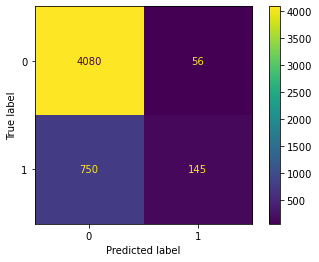

In [266]:
# Train conf matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(targets_train, logreg.predict(scaled_train))
plot_confusion_matrix(logreg_b, b_train, targets_train_b) 

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


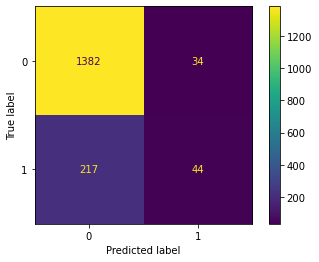

In [267]:
# Val conf matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_b, b_val, targets_val_b) 

### Simple imputation (no reg)

In [133]:
sqf_cpw_filter_simpimp = fill_missing_data(sqf_cpw_filter.copy())

In [134]:
scaled_train, scaled_val, scaled_test, targets_train, targets_val, targets_test = process_data_simpleimputer(sqf_cpw_filter_simpimp)

In [135]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='none')

logreg.fit(scaled_train, targets_train)

y_train_pred = logreg.predict_proba(scaled_train)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [136]:
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train = accuracy_score(targets_train, logreg.predict(scaled_train))
y_acc_val = accuracy_score(targets_val, logreg.predict(scaled_val))
print('acc train = ', y_acc_train)
print('acc val = ', y_acc_val)

acc train =  0.8404962906114095
acc val =  0.8468917881811205


In [137]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(targets_train, y_train_pred[:, 1])

The AUC score of my training set:


0.7283280267953146

In [138]:
# AUC score for validation set
y_val_pred = logreg.predict_proba(scaled_val)
roc_auc_score(targets_val, y_val_pred[:, 1])

0.6710821531975193

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


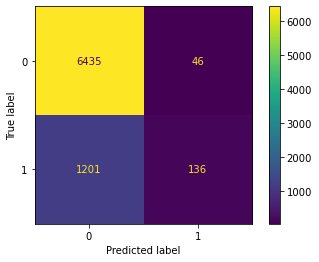

In [139]:
# Train conf matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(targets_train, logreg.predict(scaled_train))
plot_confusion_matrix(logreg, scaled_train, targets_train) 

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


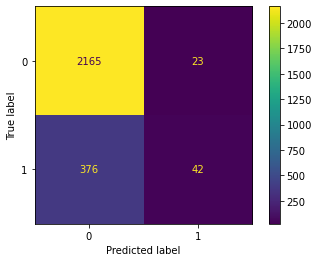

In [140]:
# Val conf matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, scaled_val, targets_val)

### Iterative imputer (no reg)

In [141]:
sqf_itimp = sqf_cpw_filter.copy()

In [144]:
# imputation (ascending order of missing values) after ohe

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

sqf_ohe = pd.get_dummies(sqf_itimp, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
                                                                   'LOCATION_IN_OUT_CODE', 
                                                                   'OFFICER_IN_UNIFORM_FLAG', 
                                                                   'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
                                                                   'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
                                                                   'SUSPECT_RACE_DESCRIPTION', 
                                                                   'SUSPECT_BODY_BUILD_TYPE', 
                                                                   'MONTH2', 'DAY2'])

imputer = IterativeImputer(random_state=100)
imputed = imputer.fit_transform(sqf_ohe)
sqf_cpw_filter_itimp = pd.DataFrame(imputed, columns=sqf_ohe.columns)

In [145]:
def process_data_itimputer(sqf_cpw):
    # train, val, test split
    train, test = train_test_split(sqf_cpw, test_size=0.2, random_state=1)
    train, val = train_test_split(train, test_size=0.25, random_state=1)
    df_train = train
    df_val = val
    df_test = test
    weapon = 'WEAPON_FOUND_FLAG_Y'
    
    # standardize columns
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(df_train)
    val_scale = scaler.transform(df_val)
    test_scale = scaler.transform(df_test)
    scaled_train = pd.DataFrame(train_scale, index=df_train.index, columns=df_train.columns)
    scaled_val = pd.DataFrame(val_scale, index=df_val.index, columns=df_val.columns)
    scaled_test = pd.DataFrame(test_scale, index=df_test.index, columns=df_test.columns)

    scaled_train_x = scaled_train.drop([weapon], axis=1)
    scaled_val_x = scaled_val.drop([weapon], axis=1)
    scaled_test_x = scaled_test.drop([weapon], axis=1)
    # targets
    targets_train = df_train[weapon]
    targets_val = df_val[weapon]
    targets_test = df_test[weapon]
    
    return scaled_train_x, scaled_val_x, scaled_test_x, targets_train, targets_val, targets_test

In [146]:
scaled_train_i, scaled_val_i, scaled_test_i, targets_train_i, targets_val_i, targets_test_i = process_data_itimputer(sqf_cpw_filter_itimp)

In [147]:
logreg_i = LogisticRegression(penalty='none')

logreg_i.fit(scaled_train_i, targets_train_i)

y_train_pred_i = logreg_i.predict_proba(scaled_train_i)

In [148]:
print('The AUC score of my training set:')
roc_auc_score(targets_train_i, y_train_pred_i[:, 1])

The AUC score of my training set:


0.7275568871300575

In [149]:
# AUC score for validation set
y_val_pred_i = logreg_i.predict_proba(scaled_val_i)
roc_auc_score(targets_val_i, y_val_pred_i[:, 1])

0.6708405132825415

### Drop missing data (with reg) - Baseline 

In [150]:
# sqf_cpw_dropped = sqf_cpw_filter.dropna()
# sqf_cpw_dropped.shape

In [151]:
# sqf_cpw_dropped_simpimp = fill_missing_data(sqf_cpw_dropped)

In [152]:
# b_train, b_val, b_test, targets_train_b, targets_val_b, targets_test_b = process_data_simpleimputer(sqf_cpw_dropped_simpimp)

In [434]:
from sklearn.linear_model import LogisticRegression

logreg_reg = LogisticRegression(penalty='l1', solver='liblinear')

logreg_reg.fit(b_train, targets_train_b)

y_train_pred_reg = logreg_reg.predict_proba(b_train)

In [435]:
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train_reg = accuracy_score(targets_train_b, logreg_reg.predict(b_train))
y_acc_val_reg = accuracy_score(targets_val_b, logreg_reg.predict(b_val))
print('acc train = ', y_acc_train_reg)
print('acc val = ', y_acc_val_reg)

acc train =  0.8405883522162592
acc val =  0.8521168753726893


In [436]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(targets_train_b, y_train_pred_reg[:, 1])

The AUC score of my training set:


0.7529578142052883

In [437]:
# AUC score for validation set
y_val_pred_reg = logreg_reg.predict_proba(b_val)
roc_auc_score(targets_val_b, y_val_pred_reg[:, 1])

0.7165860337251337

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


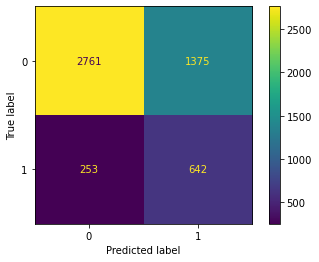

In [325]:
# Train conf matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(targets_train, logreg.predict(scaled_train))
plot_confusion_matrix(logreg_reg, b_train, targets_train_b) 

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


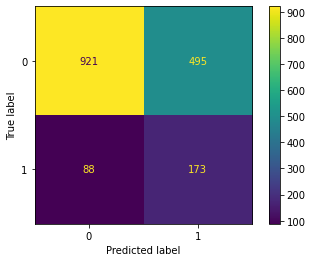

In [326]:
# Val conf matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_reg, b_val, targets_val_b) 

### Dropped, l1 reg, hyperparam selection

In [694]:
# Lasso
#creating 30 values for C between 1e-2 and 10 
import numpy as np

C_list_train_log = []
C_range_log = 10**np.linspace(-2, 0, 30)

#creating 20 instances of logistic regression for the 20 values of C
for i in C_range_log:  
    clf = LogisticRegression(C=i, penalty='l1', solver='liblinear', class_weight='balanced')
    clf.fit(b_train, targets_train_b)
    C_list_train_log.append(clf)

In [695]:
predicted_values_train = []
predicted_values_val = []
predicted_values_test = []
for classifier in C_list_train_log:
  pred_train = classifier.predict(b_train)
  pred_val = classifier.predict(b_val)
  pred_test = classifier.predict(b_test)
  predicted_values_train.append(pred_train)
  predicted_values_val.append(pred_val)
  predicted_values_test.append(pred_test)

In [696]:
len(predicted_values_test)

30

In [697]:
# checking AUC score on training predictions with l1 regularization
#from sklearn.metrics import roc_auc_score 
w_acc_train = []
for pred in predicted_values_train:
  acc_list = weighted_accuracy(targets_train_b, pred)
  w_acc_train.append(acc_list)
#auc_train

In [698]:
# checking AUC score on validation predictions with l1 regularization
w_acc_val = []
for pred in predicted_values_val:
  acc_list = weighted_accuracy(targets_val_b, pred)
  w_acc_val.append(acc_list)
#auc_val

In [699]:
predicted_values_test[0].shape

(1678,)

In [700]:
# checking AUC score on test predictions with l1 regularization
w_acc_test = []
for pred in predicted_values_test:
  acc_list = weighted_accuracy(targets_test_b, pred)
  w_acc_test.append(acc_list)
#auc_test

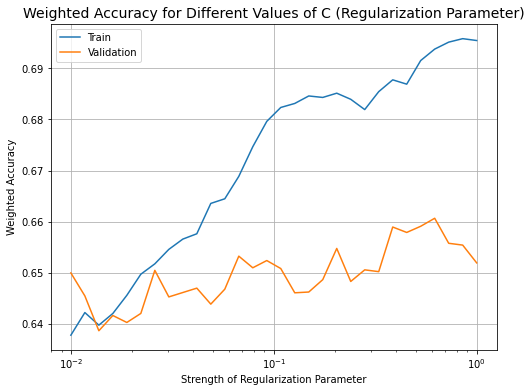

In [708]:
#plotting regularization strength vs. AUC score for train, val, and test
plt.figure(figsize=(8, 6))
plt.semilogx(C_range_log, w_acc_train, label='Train')
plt.semilogx(C_range_log, w_acc_val, label='Validation')
#plt.semilogx(C_range_log, auc_test, label='Test')
plt.xlabel("Strength of Regularization Parameter")
plt.ylabel("Weighted Accuracy")
plt.title("Weighted Accuracy for Different Values of C (Regularization Parameter)", size=14)
plt.grid()
plt.legend()
plt.show()

In [702]:
#choose C hyperparam where validation performs best
c_index = np.array(w_acc_val).argmax()
c = C_range_log[c_index]
c

0.6210169418915616

In [706]:
from sklearn.linear_model import LogisticRegression
logreg_c = LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=101, class_weight='balanced')
logreg_c.fit(b_train, targets_train_b)
y_train_pred_c = logreg_c.predict_proba(b_train)
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train_c = weighted_accuracy(targets_train_b, logreg_c.predict(b_train))
y_acc_val_c = weighted_accuracy(targets_val_b, logreg_c.predict(b_val))
print('w acc train = ', y_acc_train_c)
print('w acc val = ', y_acc_val_c)

w acc train =  0.6937343991441816
w acc val =  0.660671959218131


In [733]:
y_acc_test_c = weighted_accuracy(targets_test_b, logreg_c.predict(b_test))
print('w acc test = ', y_acc_test_c)

w acc test =  0.6789406583217431


In [337]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(targets_train_b, y_train_pred_c[:, 1])

The AUC score of my training set:


0.7346209329716996

In [338]:
# AUC score for validation set
y_val_pred_c = logreg_c.predict_proba(b_val)
roc_auc_score(targets_val_b, y_val_pred_c[:, 1])

0.7195759464900319

#### Confusion matrix, precision, recall, etc. 

In [171]:
from sklearn.metrics import classification_report
print(classification_report(targets_train_b, logreg_c.predict(b_train)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4136
           1       0.81      0.12      0.20       895

    accuracy                           0.84      5031
   macro avg       0.82      0.55      0.56      5031
weighted avg       0.83      0.84      0.78      5031



In [172]:
# from sklearn.pipeline import make_pipeline

# # classifier = make_pipeline(LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=101))
# # classifier.fit(b_train, targets_train_b)

# from sklearn.metrics import PrecisionRecallDisplay
# display = PrecisionRecallDisplay.from_predictions(targets_val_b, y_val_pred_c, name="LinearSVC")
# _ = display.ax_.set_title("2-class Precision-Recall curve")

In [173]:
#TO DO 

#### Class weights

In [438]:
print(targets_train_b.shape)
print(targets_train_b.sum())
print(targets_train_b.shape[0] - targets_train_b.sum())

(5031,)
895
4136


In [707]:
from sklearn.linear_model import LogisticRegression
logreg_weights = LogisticRegression(penalty='l1', solver='liblinear', max_iter=101, 
                                    class_weight='balanced')
logreg_weights.fit(b_train, targets_train_b)
y_train_pred_weights = logreg_weights.predict_proba(b_train)
y_val_pred_weights = logreg_weights.predict_proba(b_val)
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train_weights = accuracy_score(targets_train_b, logreg_weights.predict(b_train))
y_acc_val_weights = accuracy_score(targets_val_b, logreg_weights.predict(b_val))
print('acc train = ', y_acc_train_weights)
print('acc val = ', y_acc_val_weights)

acc train =  0.7014510037765852
acc val =  0.6708407871198568


In [683]:
# feature_importance = abs(logreg_weights.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)
# subset = sorted_idx[-30:-1]
# pos = np.arange(subset.shape[0]) + .5

# featfig = plt.figure()
# featax = featfig.add_subplot(1, 1, 1)
# featax.barh(pos, feature_importance[subset], align='center')
# featax.set_yticks(pos)
# featax.set_yticklabels(np.array(X.columns)[subset], fontsize=8)
# featax.set_xlabel('Relative Feature Importance')

# plt.tight_layout()   
# plt.show()

In [442]:
# Weighted accuracy
y_wacc_train_weights = weighted_accuracy(targets_train_b, logreg_weights.predict(b_train))
y_wacc_val_weights = weighted_accuracy(targets_val_b, logreg_weights.predict(b_val))
print('weightedacc train = ', y_wacc_train_weights)
print('weighted acc val = ', y_wacc_val_weights)

weightedacc train =  0.6842866289184487
weighted acc val =  0.6486744269108383


In [294]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(targets_train_b, y_train_pred_weights[:, 1])

The AUC score of my training set:


0.7499413786023794

In [295]:
# AUC score for validation set
y_val_pred_c = logreg_c.predict_proba(b_val)
roc_auc_score(targets_val_b, y_val_pred_weights[:, 1])

0.7161720458038402

In [296]:
from sklearn.metrics import recall_score
recall_train_weights = recall_score(targets_train_b, logreg_weights.predict(b_train))
recall_val_weights = recall_score(targets_val_b, logreg_weights.predict(b_val))
print ('Train recall = ', recall_train_weights)
print('Val recall = ', recall_val_weights)

Train recall =  0.6983240223463687
Val recall =  0.6666666666666666


In [732]:
sp_train_weights = specificity(targets_train_b, logreg_weights.predict(b_train))
sp_val_weights = specificity(targets_val_b, logreg_weights.predict(b_val))
print ('Train specificity = ', sp_train_weights)
print('Val specificity = ', sp_val_weights)

Train specificity =  0.42504835589941975
Val specificity =  0.4004237288135593


In [298]:
#f1 score
from sklearn.metrics import f1_score
f1_train_weights = f1_score(targets_train_b, logreg_weights.predict(b_train))
f1_val_weights = f1_score(targets_val_b, logreg_weights.predict(b_val))
print('Train F1 = ', f1_train_b)
print('Val F1 = ', f1_val_b)

Train F1 =  0.2645985401459854
Val F1 =  0.25958702064896755


/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


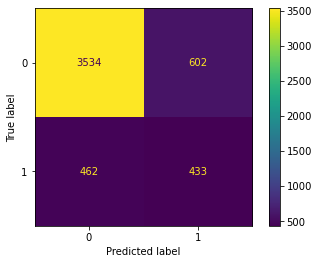

In [245]:
# Train conf matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(targets_train, logreg.predict(scaled_train))
plot_confusion_matrix(logreg_weights, b_train, targets_train_b) 

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


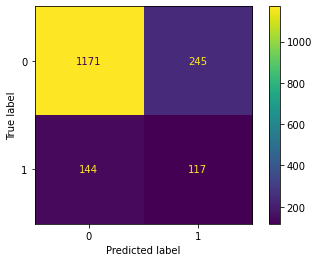

In [246]:
# Val conf matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_weights, b_val, targets_val_b) 

In [662]:
from sklearn.metrics import roc_curve

train_roc_scores = y_train_pred_weights[:, 1]
fpr, tpr, thresholds = roc_curve(targets_train_b, train_roc_scores)

Text(0.5, 1.0, 'Receiver operating characteristic')

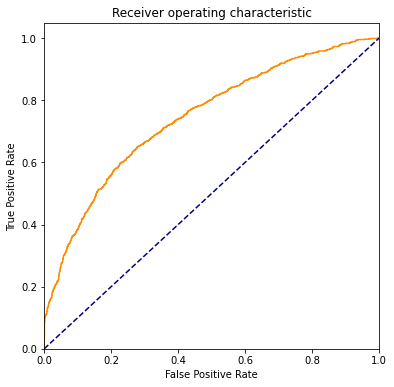

In [663]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

In [247]:
from sklearn.metrics import classification_report
print(classification_report(targets_train_b, logreg_weights.predict(b_train)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      4136
           1       0.42      0.48      0.45       895

    accuracy                           0.79      5031
   macro avg       0.65      0.67      0.66      5031
weighted avg       0.80      0.79      0.79      5031



In [248]:
from sklearn.metrics import recall_score
print(recall_score(targets_train_b, logreg_weights.predict(b_train)))

0.48379888268156424


#### Optimize max_iter for log loss?

In [712]:
c

0.6210169418915616

In [713]:
from sklearn.metrics import log_loss
ll = []

step = np.arange(1, 2000, 50)

for i in step:
    logreg = LogisticRegression(penalty='l1', max_iter=i, solver='liblinear', class_weight='balanced', C=c)
    logreg.fit(scaled_train, targets_train)
    loss = log_loss(targets_train, logreg.predict(scaled_train))
    #print(i, loss)
    ll.append(loss)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Text(0.5, 1.0, 'Loss curve for Logistic Regression model')

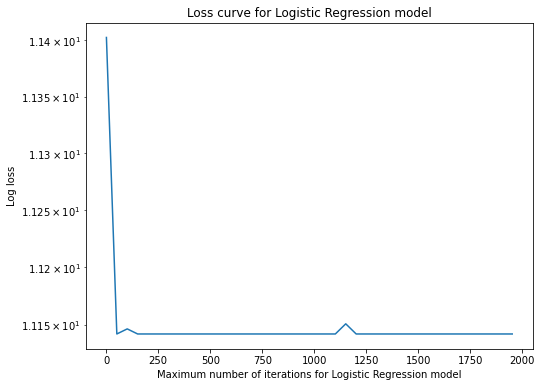

In [731]:
plt.figure(figsize=(8,6))
plt.plot(step, ll)
plt.yscale('log')
plt.xlabel('Maximum number of iterations for Logistic Regression model')
plt.ylabel('Log loss')
plt.title('Loss curve for Logistic Regression model')

In [178]:
#choose max_iter hyperparam where log loss is minimum
max_iter_index = np.array(ll).argmin()
max_iter = step[max_iter_index]
max_iter

101

### PCA (DR) + dropped + l1 reg with optimal c

In [373]:
sqf_cpw_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 0 to 13030
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      8386 non-null   object 
 1   STOP_LOCATION_PRECINCT     8386 non-null   object 
 2   LOCATION_IN_OUT_CODE       8386 non-null   object 
 3   JURISDICTION_CODE          8386 non-null   object 
 4   OBSERVED_DURATION_MINUTES  8386 non-null   float64
 5   OFFICER_IN_UNIFORM_FLAG    8386 non-null   object 
 6   STOP_WAS_INITIATED         8386 non-null   object 
 7   SUSPECT_SEX                8386 non-null   object 
 8   SUSPECT_RACE_DESCRIPTION   8386 non-null   object 
 9   SUSPECT_REPORTED_AGE       8386 non-null   float64
 10  SUSPECT_WEIGHT             8386 non-null   float64
 11  SUSPECT_BODY_BUILD_TYPE    8386 non-null   object 
 12  WEAPON_FOUND_FLAG          8386 non-null   object 
 13  SUSPECT_HEIGHT             8386 non-null   floa

In [374]:
# OHE

sqf_ohe_pca = pd.get_dummies(sqf_cpw_dropped, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
                                                                   'LOCATION_IN_OUT_CODE', 
                                                                   'OFFICER_IN_UNIFORM_FLAG', 
                                                                   'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
                                                                   'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
                                                                   'SUSPECT_RACE_DESCRIPTION', 
                                                                   'SUSPECT_BODY_BUILD_TYPE', 
                                                                   'MONTH2', 'DAY2'])

In [375]:
df_imputed_dr = sqf_ohe_pca

In [376]:
from sklearn.model_selection import train_test_split

train_dr, test_dr = train_test_split(df_imputed_dr, test_size=0.2, random_state=1)

train_dr, val_dr = train_test_split(train_dr, test_size=0.25, random_state=1)

In [377]:
train_targets_pca = train_dr['WEAPON_FOUND_FLAG_Y']
train_dr = train_dr.drop(columns='WEAPON_FOUND_FLAG_Y')
val_targets_pca = val_dr['WEAPON_FOUND_FLAG_Y']
val_dr = val_dr.drop(columns='WEAPON_FOUND_FLAG_Y')
test_targets_pca = test_dr['WEAPON_FOUND_FLAG_Y']
test_dr = test_dr.drop(columns='WEAPON_FOUND_FLAG_Y')

In [378]:
from sklearn.preprocessing import StandardScaler

scaler_pca = StandardScaler()
train_pca = scaler_pca.fit_transform(train_dr)
train_pca_df = pd.DataFrame(train_pca, index=train_dr.index, columns=train_dr.columns)
val_pca = scaler_pca.transform(val_dr)
val_pca_df = pd.DataFrame(val_pca, index=val_dr.index, columns=val_dr.columns)
test_pca = scaler_pca.transform(test_dr)
test_pca_df = pd.DataFrame(test_pca, index=test_dr.index, columns=test_dr.columns)

In [379]:
train_pca_df.shape

(5031, 118)

In [380]:
from sklearn.decomposition import PCA

n_components = np.linspace(1, train_pca_df.shape[1], train_pca_df.shape[1], dtype=int)
explained_variance_marginal = []
explained_variance_cumulative = []

for i in n_components:
  pca = PCA(n_components=i)
  pca.fit(train_pca_df)
  explained_variance_marginal.append(pca.explained_variance_ratio_[i-1])
  explained_variance_cumulative.append(np.sum(pca.explained_variance_ratio_))

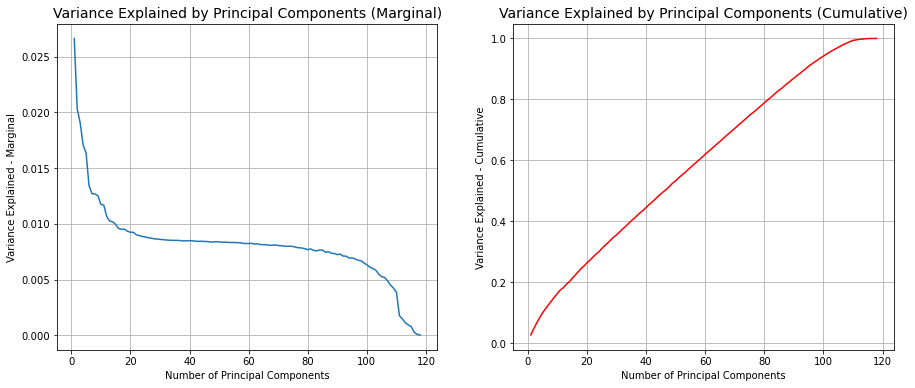

In [381]:
# figure for report
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(n_components, explained_variance_marginal)
#axes[0].scatter(n_components, explained_variance_marginal)
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Variance Explained - Marginal")
axes[0].set_title("Variance Explained by Principal Components (Marginal)", size=14)
axes[0].grid()

#axes[1].scatter(n_components, explained_variance_cumulative, color='red')
axes[1].plot(n_components, explained_variance_cumulative, color='red')
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Variance Explained - Cumulative")
axes[1].set_title("Variance Explained by Principal Components (Cumulative)", size=14)
axes[1].grid()

In [729]:
n_comp = 95

In [730]:
# train pca
pca = PCA(n_components=n_comp)
pca_train_data = pca.fit_transform(train_pca_df)
pca.explained_variance_ratio_.sum()

0.9091160245294767

In [720]:
# val pca
pca_val_data = pca.transform(val_pca_df)

In [721]:
# test pca
pca_test_data = pca.transform(test_pca_df)

In [722]:
cols = np.linspace(1, n_comp, n_comp, dtype=int)
pca_train_data_df = pd.DataFrame(data = pca_train_data, columns=cols, index=train_pca_df.index)
pca_val_data_df = pd.DataFrame(data = pca_val_data, columns=cols, index=val_pca_df.index)
pca_test_data_df = pd.DataFrame(data = pca_test_data, columns=cols, index=test_pca_df.index)

In [723]:
#pca_train_data_df

In [724]:
from sklearn.linear_model import LogisticRegression
logreg_pca = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=c, class_weight='balanced')
logreg_pca.fit(pca_train_data_df, train_targets_pca)
y_train_pred_pca = logreg_pca.predict_proba(pca_train_data_df)
y_acc_train_pca = weighted_accuracy(train_targets_pca, logreg_pca.predict(pca_train_data_df))
y_acc_val_pca = weighted_accuracy(val_targets_pca, logreg_pca.predict(pca_val_data_df))
print('acc train = ', y_acc_train_pca)
print('acc val = ', y_acc_val_pca)

acc train =  0.6754122407961705
acc val =  0.6587562504058706


In [413]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(train_targets_pca, y_train_pred_pca[:, 1])

The AUC score of my training set:


0.7526341808672724

In [414]:
# AUC score for validation set
y_val_pred_pca = logreg_pca.predict_proba(pca_val_data)
roc_auc_score(val_targets_pca, y_val_pred_pca[:, 1])

0.7101949260774509

### Sampling with dropped data

In [ ]:
#sqf_cpw_dropped

In [139]:
sqf_sample = pd.get_dummies(sqf_cpw_dropped, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
                                                                   'LOCATION_IN_OUT_CODE', 
                                                                   'OFFICER_IN_UNIFORM_FLAG', 
                                                                   'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
                                                                   'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
                                                                   'SUSPECT_RACE_DESCRIPTION', 
                                                                   'SUSPECT_BODY_BUILD_TYPE', 
                                                                   'MONTH2', 'DAY2'])

In [140]:
from sklearn.model_selection import train_test_split
train_sample, test_sample = train_test_split(sqf_sample, test_size=0.2, random_state=1)
train_sample, val_sample = train_test_split(train_sample, test_size=0.25, random_state=1)
train_targets_sample = train_sample['WEAPON_FOUND_FLAG_Y']
train_sample = train_sample.drop(columns='WEAPON_FOUND_FLAG_Y')
val_targets_sample = val_sample['WEAPON_FOUND_FLAG_Y']
val_sample = val_sample.drop(columns='WEAPON_FOUND_FLAG_Y')
# test_targets_pca = test_dr['WEAPON_FOUND_FLAG_Y']
# test_dr = test_dr.drop(columns='WEAPON_FOUND_FLAG_Y')

In [212]:
train_sample

,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_WEIGHT,SUSPECT_HEIGHT,STOP_FRISK_TIME,YEAR2_two thousand and fifteen,YEAR2_two thousand and nineteen,YEAR2_two thousand and seventeen,YEAR2_two thousand and sixteen,...,MONTH2_ten,MONTH2_three,MONTH2_twelve,MONTH2_two,DAY2_four,DAY2_one,DAY2_six,DAY2_three,DAY2_two,DAY2_zero
7787,2.0,10.0,46.0,110.0,4.800000,14.083333,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3315,5.0,5.0,19.0,150.0,5.750000,50.833333,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5427,1.0,8.0,24.0,190.0,5.110000,1.500000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
10150,1.0,6.0,29.0,120.0,5.400000,13.833333,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4480,0.0,5.0,23.0,190.0,5.900000,20.000000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12894,1.0,2.0,50.0,165.0,5.100000,20.083333,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4766,2.0,5.0,38.0,170.0,5.100000,13.216667,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4018,1.0,10.0,25.0,170.0,6.300000,3.500000,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3452,1.0,10.0,46.0,160.0,5.750000,2.000000,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [159]:
categorical = np.arange(6, 119, 1)

In [170]:
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# sme = SMOTENC(categorical_features=categorical)
# X_res, y_res = sme.fit_resample(train_sample, train_targets_sample)

# define resampling
over = SMOTENC(categorical_features=categorical)
under = RandomUnderSampler()
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_res, y_res = pipeline.fit_resample(train_sample, train_targets_sample)

In [171]:
from sklearn.linear_model import LogisticRegression
logreg_sample = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=c)
logreg_sample.fit(X_res, y_res)
y_train_pred_sample = logreg_sample.predict_proba(X_res)
y_val_pred_sample = logreg_sample.predict_proba(val_sample)
print('acc train = ', accuracy_score(y_res, logreg_sample.predict(X_res)))      
print('acc val = ', accuracy_score(val_targets_sample, logreg_sample.predict(val_sample)))

acc train =  0.8930188229687872
acc val =  0.8306499701848539


In [175]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set: ', roc_auc_score(y_res, y_train_pred_sample[:, 1]))
print('The AUC score of my validation set: ', roc_auc_score(val_targets_sample, y_val_pred_sample[:, 1]))

The AUC score of my training set:  0.9443604526168862
The AUC score of my validation set:  0.7296104327017339


### Increase train set size

In [202]:
sqf_cross_val = sqf_cpw_dropped.copy()

In [253]:
train_lr, val_lr, test_lr, targets_train_lr, targets_val_lr, targets_test_lr = process_data_simpleimputer(sqf_cross_val, t1=0.1, t2=0.1111)

0.1 0.1111


In [254]:
targets_val_lr

0        0.0
1        0.0
2        0.0
11       0.0
15       NaN
        ... 
13012    0.0
13015    0.0
13022    0.0
13023    0.0
13024    0.0
Name: WEAPON_FOUND_FLAG_Y, Length: 2348, dtype: float64

In [273]:
# from sklearn.linear_model import LogisticRegression
# logreg_lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=c)
# logreg_lr.fit(train_lr, targets_train_lr)
# y_train_pred_lr = logreg_lr.predict_proba(train_lr)
# y_val_pred_lr = logreg_lr.predict_proba(val_lr)
# print('acc train = ', accuracy_score(targets_train_lr, logreg_lr.predict(train_lr)))      
# print('acc val = ', accuracy_score(targets_val_lr, logreg_lr.predict(val_lr)))

In [193]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set: ', roc_auc_score(targets_train_lr, y_train_pred_lr[:, 1]))
print('The AUC score of my validation set: ', roc_auc_score(targets_val_lr, y_val_pred_lr[:, 1]))

The AUC score of my training set:  0.7346163405119781
The AUC score of my validation set:  0.7195813580968462


### Cross validation

In [ ]:
# # evaluate a logistic regression model using repeated k-fold cross-validation
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# # prepare the cross-validation procedure
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # create model
# model = LogisticRegression()
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

### Class weights iterative (for imbalance)

Main metrics are specificity and recall - we want to try and find a balance between the two 

In [737]:
from sklearn.linear_model import LogisticRegression
w = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]
r_train = []
r_val = []
s_train = []
s_val = []

for i in w:
    logreg_weights = LogisticRegression(penalty='none',
                                        class_weight={0: 1, 1: i})
    logreg_weights.fit(b_train, targets_train_b)
    recall_train_b = recall_score(targets_train_b, logreg_weights.predict(b_train))
    r_train.append(recall_train_b)
    recall_val_b = recall_score(targets_val_b, logreg_weights.predict(b_val))
    r_val.append(recall_val_b)
    sp_train_b = specificity(targets_train_b, logreg_weights.predict(b_train))
    s_train.append(sp_train_b)
    sp_val_b = specificity(targets_val_b, logreg_weights.predict(b_val))
    s_val.append(sp_val_b)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Text(0.5, 1.0, 'Recall and specificity trade-off as weight of class 1 increases')

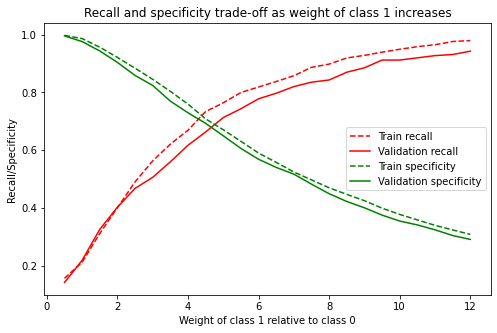

In [740]:
plt.figure(figsize=(8,5))
plt.plot(w, np.array(r_train)+0.05, c='red', label='Train recall', ls='--')
plt.plot(w, np.array(r_val)+0.05, c='red', label='Validation recall')
plt.plot(w, s_train, c='green', label='Train specificity', ls='--')
plt.plot(w, s_val, c='green', label='Validation specificity')
plt.xlabel('Weight of class 1 relative to class 0')
plt.ylabel('Recall/Specificity')
plt.legend()
plt.title('Recall and specificity trade-off as weight of class 1 increases')

#### It seems that weight = 5 provides the optimal balance between recall and specificity

### Adjust Thresholds

In [656]:
from sklearn.linear_model import LogisticRegression
t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rt_train = []
rt_val = []
st_train = []
st_val = []
wa_train = []
wa_val = []
a_train = []
a_val = []

logreg_t = LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=101, class_weight='balanced')
logreg_t.fit(b_train, targets_train_b)

for i in t:
    y_pred_train = (logreg_t.predict_proba(b_train)[:,1]>=i).astype(int)
    y_pred_val = (logreg_t.predict_proba(b_val)[:,1]>=i).astype(int)
    
    recall_train_b = recall_score(targets_train_b, y_pred_train)
    rt_train.append(recall_train_b)
    recall_val_b = recall_score(targets_val_b, y_pred_val)
    rt_val.append(recall_val_b)
    
    sp_train_b = specificity(targets_train_b, y_pred_train)
    st_train.append(sp_train_b)
    sp_val_b = specificity(targets_val_b, y_pred_val)
    st_val.append(sp_val_b)
    
    wacc_train_b = weighted_accuracy(targets_train_b, y_pred_train)
    wa_train.append(wacc_train_b)
    wacc_val_b = weighted_accuracy(targets_val_b, y_pred_val)
    wa_val.append(wacc_val_b)
    
    acc_train_b = accuracy_score(targets_train_b, y_pred_train)
    a_train.append(acc_train_b)
    acc_val_b = accuracy_score(targets_val_b, y_pred_val)
    a_val.append(acc_val_b)

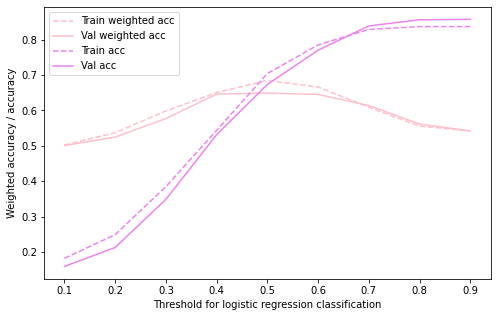

In [661]:
plt.figure(figsize=(8,5))
plt.plot(t, wa_train, c='pink', label='Train weighted acc', ls='--')
plt.plot(t, wa_val, c='pink', label='Val weighted acc')
plt.plot(t, a_train, c='violet', label='Train acc', ls='--')
plt.plot(t, a_val, c='violet', label='Val acc')
plt.xlabel('Threshold for logistic regression classification')
plt.ylabel('Weighted accuracy / accuracy')
plt.legend()

In [667]:
optimal_t_index = np.array(wa_val).argmax()
optimal_t = t[optimal_t_index]
optimal_t

0.5

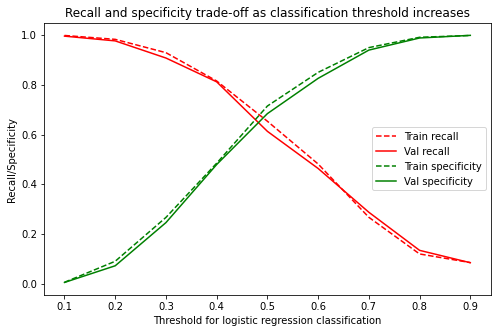

In [741]:
plt.figure(figsize=(8,5))
plt.plot(t, rt_train, c='red', label='Train recall', ls='--')
plt.plot(t, rt_val, c='red', label='Validation recall')
plt.plot(t, st_train, c='green', label='Train specificity', ls='--')
plt.plot(t, st_val, c='green', label='Validation specificity')
plt.xlabel('Threshold for logistic regression classification')
plt.ylabel('Recall/Specificity')
plt.title('Recall and specificity trade-off as classification threshold increases')
plt.legend()

### Learning curve

In [631]:
weapon = 'WEAPON_FOUND_FLAG_Y'
df_num = sqf_cpw_dropped.select_dtypes(['float64', 'int64'])
df_cat = sqf_cpw_dropped.select_dtypes(['object', 'string'])
cat = df_cat.columns
df_ohe = pd.get_dummies(df_cat, prefix=cat, columns=cat, drop_first=True)
df_join = df_num.join(df_ohe, how='outer')

In [634]:
data, X_test = train_test_split(df_join, test_size=0.1, random_state=1)

In [635]:
# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [636]:
num_cols = df_num.columns

In [637]:
#Creating ss transformer to scale the continuous numerical data with StandardScaler()
ss = Pipeline(steps=[('ss', StandardScaler())])

#Creating preprocess column transformer to combine the ss and ohe pipelines
preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, num_cols),
                    ])

In [639]:
classifier = LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=101, 
                                    class_weight='balanced')

In [643]:
def cross_validate(classifier, cv):
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ])
    train_wacc = []
    test_wacc = []
    #a1, a2 = cv.split(X_train, y_train)
    #print(a1)
    for train_ind, val_ind in cv.split(X, y):
#         print(type(list(train_ind)), len(train_ind))
        X_t, y_t = X.iloc[train_ind], y.iloc[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_wacc.append(weighted_accuracy(y_t, y_hat_t))
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_wacc.append(weighted_accuracy(y_val, y_hat_val))

    print('Training W Accuracy: {}'.format(np.mean(train_wacc)))
    print('Validation W Accuracy: {}'.format(np.mean(test_wacc)))

In [644]:
X = data.drop(['WEAPON_FOUND_FLAG_Y'], axis=1)
y = data['WEAPON_FOUND_FLAG_Y']
#y = LabelEncoder().fit_transform(y)

In [648]:
cross_validate(classifier, KFold(n_splits=10, shuffle=True, random_state=0))

Training W Accuracy: 0.566015303301794
Validation W Accuracy: 0.5593609043658695


In [ ]:
# remove test data
# one hot encode 
# pipiline - train val split, standardize 